# **Lab Assignment 1**
🎯**Objective:** Optimize cut-off energy and k-points grid parameters and implement them for structure relaxation.

---
# Import and Initialization
---

## **General Workflow**
✅1) **Import and Initialization**
- To begin with, let's import the essential (for this assignment) libraries.
- Fill the parameter **struc** name. The file with **struc** name will be created and all calculations will be saved there. 
- Other cells must be run without any changes.
- For the first time you need to fill **struc**. But in the next times, when you will use this notebook, you can just completely run all cells in part *Import and Initialization* without any changes.

## Library

In [43]:
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import re
from ase.io.vasp import read_vasp_out, write_vasp, read_vasp_xml
from ase.io import write, read
from ase.calculators.vasp import Vasp
from ase.geometry import cell_to_cellpar
from ase.build import make_supercell, graphene
from ase import Atoms, Atom
from ase.io.lammpsdata import read_lammps_data
from ase.units import GPa
from calorine.calculators import CPUNEP, GPUNEP
from calorine.tools import relax_structure
from PIL import Image

from mendeleev import element
from pymatgen.io.vasp import Vasprun
from pymatgen.core.structure import Structure
from pymatgen.electronic_structure.core import Spin
from ase.calculators.espresso import Espresso, EspressoProfile
#from pymatgen.io.espresso.outputs import PWxml

import time
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader

from pathlib import Path, PurePath
import sys
sys.path.append(os.getcwd() + '/python_files')
from util_functions import *

from threading import Thread
from multiprocessing import Pool, Process
from collections import defaultdict
import shutil

pd.options.plotting.backend = "plotly"

> **IMPORTANT**

> Insert **YOUR STRUCTURE NAME** file that will be used further. All calculations will be saved there.

In [44]:
# Insert structure name
struc = 'Diamane' # Diamane

## Import Working Directories

Load directories

In [45]:
general_paths_dir = Path(os.getcwd()) / struc / 'utils' / 'general_paths.yaml'

if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

# Create structure name key in pathes
if struc not in general_paths.keys():
    general_paths[struc] = Munch()
    general_paths[struc]['__val__'] = create_folder(main_dir=Path(os.getcwd()), folder=struc)
    general_paths['utils'] = create_folder(main_dir=general_paths[struc]['__val__'], folder='utils')
    general_paths['figures'] = create_folder(main_dir=general_paths[struc]['__val__'], folder='figures')

Folder Diamane is created
Folder utils is created
Folder figures is created


Create working directories and save them

In [46]:
save_path(
    main_dir=create_folder(main_dir=general_paths[struc].__val__, folder='1.Optimization'), 
    dir_name='qe_opt_params',
    general_paths_dir=general_paths_dir,
    munch_dict=general_paths[struc],
    general_dict=general_paths,
    )

save_path(
        main_dir=create_folder(main_dir=general_paths[struc].qe_opt_params.__val__, folder='1.1.Cutoff_energy_Optimization'),
        dir_name='cutoff_energy_opt',
        general_paths_dir=general_paths_dir,
        munch_dict=general_paths[struc]['qe_opt_params'],
        general_dict=general_paths,
        )

save_path(
        main_dir=create_folder(main_dir=general_paths[struc].qe_opt_params.__val__, folder='1.2.Kpoints_Optimization'),
        dir_name='kpoints_opt',
        general_paths_dir=general_paths_dir,
        munch_dict=general_paths[struc]['qe_opt_params'],
        general_dict=general_paths,
        )

save_path(
        main_dir=create_folder(main_dir=general_paths[struc].qe_opt_params.__val__, folder='1.3.Relaxation'),
        dir_name='relaxation',
        general_paths_dir=general_paths_dir,
        munch_dict=general_paths[struc]['qe_opt_params'],
        general_dict=general_paths,
        )

with (general_paths_dir).open(mode='w') as f:
    yaml.dump(munch_to_dict(general_paths), f)
    f.close()

Folder 1.Optimization is created
File path is saved
Folder 1.1.Cutoff_energy_Optimization is created
File path is saved
Folder 1.2.Kpoints_Optimization is created
File path is saved
Folder 1.3.Relaxation is created
File path is saved


---
# PART 1 - Parameter Optimization and Relaxation
---

## Functions and Files

### **General Workflow**
✅2) **Initialize functions and download essential files**
- Mentioned below functions will be used for general calculation of some parameters. In most cases, they **DO NOT** need to change.

- You need to prepare **POSCAR** file of your structure. You can take the crystal structure of your own material. <br>
If you do not have your own material, you can choose one of them here: <br>
https://next-gen.materialsproject.org/materials <br>
Materials Project website contains information about most of the existing structures. You need to download **POSCAR** file.

- You need to download pseudopotentials for each atom in your structure. **PSEUDOPOTENTIALS** for atoms you can find here: <br>
QUANTUM ESPRESSO: https://pseudopotentials.quantum-espresso.org/legacy_tables <br>
PSEUDO_DOJO: http://www.pseudo-dojo.org/index.html <br>

> **IMPORTANT** Please, place **POSCAR** and **PSEUDOPOTENTIALS** in the **UTILS** directory. <br>

- There is no need to add the code, just run the cells

In [47]:
def get_total_energy(outfile, file_num):
    total_energy = 0
    with open(outfile) as f:
        for line in f:
            # Parameters
            if 'number of atoms/cell      =' in line:
                natoms = int(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
            # SCF convergence data
            elif "!    total energy              =" in line:
                total_energy = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
    
    if not total_energy:
        print(f'Total energy is not found in {file_num} file')

    return total_energy


command = 'sh qe_run.sh'

**QE-run.sh**

In [48]:
%%writefile {general_paths[struc].qe_opt_params.__val__ / 'qe_run.sh'}
#!/bin/bash

mpirun -n 4 pw.x < espresso.pwi > espresso.pwo

Writing /home/heimao/Desktop/hasaki/Diamane/1.Optimization/qe_run.sh


## PART 1.1 - Cut-off Energy Optimization

### **General Workflow**
✅3) **Implement SCF calculations for cut-off energy optimization**
- Firstly, you need to fill the function **get_scf_params** (you can find it in the cell below) by parameters for your structure. This function will be used for initialization of the input file for SCF calculation. The mentioned parameters in the function are used as example. You can add/remove some of them. You will use this function for other parts of calculation as well.

You can read **DOCUMENTATION for INPUT** files: <br>
https://www.quantum-espresso.org/documentation/input-data-description/

**EXAMPLE:** <br>
```
&CONTROL
   calculation      = 'scf'               # DO NOT change
   verbosity        = 'high'              # Standard
   restart_mode     = 'from_scratch'      # DO NOT change
   tstress          = .true.              # Standard 
   tprnfor          = .true.              # Standard 
   outdir           = '.'                 # DO NOT change 
   prefix           = prefix              # DO NOT change 
   pseudo_dir       = ''                  # Will be generated automatically 
/
&SYSTEM
   ibrav            = 0                   # Choose correctly
   nat              = nat                 # Will be generated automatically
   ntyp             = ntyp                # Will be generated automatically
   ecutwfc          = ecutwfc             # Will be generated automatically
   ecutrho          = 360.0               # Choose correctly
   nosym            = .true.              # Choose correctly
   occupations      = 'smearing'          # Standard
   degauss          = 0.05                # Standard
   smearing         = 'cold'              # Standard
/
&ELECTRONS
   conv_thr         = 1e-08               # Choose correctly
   mixing_beta      = 0.4                 # Choose correctly
   diagonalization  = 'cg'                # Choose correctly
/
&IONS
   ion_dynamics     = 'bfgs'              # Choose correctly
```

- In the next cell, **cutoff_energies** and **kpts_vals** must be wisely specified. **kpts_vals** will be fixed, while **cutoff_energies** will be iteratively inserted into INPUT files and SCF will be implemented.

- After implementation above steps, please, go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/*struc*/1.Optimization/1.1.Cutoff_energy_Optimization <br>

🌟Run calculations: **sbatch scf_script.sh** <br>
If calculations successfully finished, you will see note **JOB DONE** in the **espresso.pwo** files. If it is done, you can go to the next step.

- In the visualisation part, you need run cells and obtain the figure. This figure must be used in your **Lab Report**


### SCF Calculation

In [49]:
%%writefile {general_paths[struc].qe_opt_params.cutoff_energy_opt.__val__  / 'QE_SCF_script.py'}

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import re
import ast
from ase.calculators.espresso import Espresso, EspressoProfile
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import argparse
import sys
from pathlib import Path, PurePath


parser = argparse.ArgumentParser(description='Process input data')
parser.add_argument('--main_dir', type=str, help='Enter path to the main directory')
parser.add_argument('--struc', type=str, help='Enter structure name: (e.g. Diamane)')
parser.add_argument('--cutoff_energies', type=str)
parser.add_argument('--kpts_vals', type=str)
args = parser.parse_args()

cutoff_energies = ast.literal_eval(args.cutoff_energies)
kpts_vals = ast.literal_eval(args.kpts_vals)
sys.path.append(args.main_dir + '/python_files')
from util_functions import *

general_paths_dir = Path(args.main_dir) / args.struc / 'utils' / 'general_paths.yaml'
if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

command = 'sh qe_run.sh'

def get_scf_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,

):
    scf_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                'restart_mode': 'from_scratch',
                'calculation': 'scf',
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high'
            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'ecutwfc': ecutwfc,
                'ecutrho': ecutwfc*8,     # ! 8*ecutwfc
                'nosym': True,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.05,
            },
            'electrons': {
                'conv_thr': 1.0e-8,
                'mixing_beta': 0.4,
                'diagonalization': 'cg'
            },
            'ions': {
                'ion_dynamics': 'bfgs'
            }
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return scf_params

if __name__ == '__main__':
    for i, ecutwfc in enumerate(cutoff_energies):
        # Create Folder
        folder_name = create_folder(main_dir=general_paths[args.struc].qe_opt_params.cutoff_energy_opt.__val__, folder=str(i+1))
        assert os.path.exists(general_paths.utils / 'POSCAR'), f'POSCAR file is not found in utils'
        
        structure = read(general_paths.utils / 'POSCAR')

        os.system(f'cp {general_paths[args.struc].qe_opt_params.__val__ / "qe_run.sh"} {folder_name}')
        os.chdir(folder_name)

        # SCF
        scf_params = get_scf_params(
            command=command,
            pseudo_dir=general_paths.utils,
            structure=structure,
            prefix=i+1,
            ecutwfc=int(ecutwfc),
            kpts_grid=kpts_vals,
        )
        calc = Espresso(**scf_params)
        structure.calc = calc
        structure.get_potential_energy()
        print(f'\nSCF {i+1} finished successfully\n')

Writing /home/heimao/Desktop/hasaki/Diamane/1.Optimization/1.1.Cutoff_energy_Optimization/QE_SCF_script.py


In [50]:
# Create list of cutoff energies
cutoff_energies = [x for x in range(10, 61, 5)] # CHANGE HERE
# Fixed kpoints grid
kpts_vals = [12, 12, 1] # CHANGE HERE

create_bash_script(
script_filename=general_paths[struc].qe_opt_params.cutoff_energy_opt.__val__ / 'scf_script.sh',
job_name='qe-scf',
partition='cpu',
nodes=1,
memory='6G',
exclude='',
ntasks=4,
cpus_per_task=1,
gpus=0,
time=24,
command=f'python QE_SCF_script.py \
    --struc={struc} \
    --main_dir={os.getcwd()} \
    --cutoff_energies="{str(cutoff_energies)}" \
    --kpts_vals="{str(kpts_vals)}"'
)

> **RUN CALCULATIONS** <br>

`sbatch scf_script.sh`

### Visualization

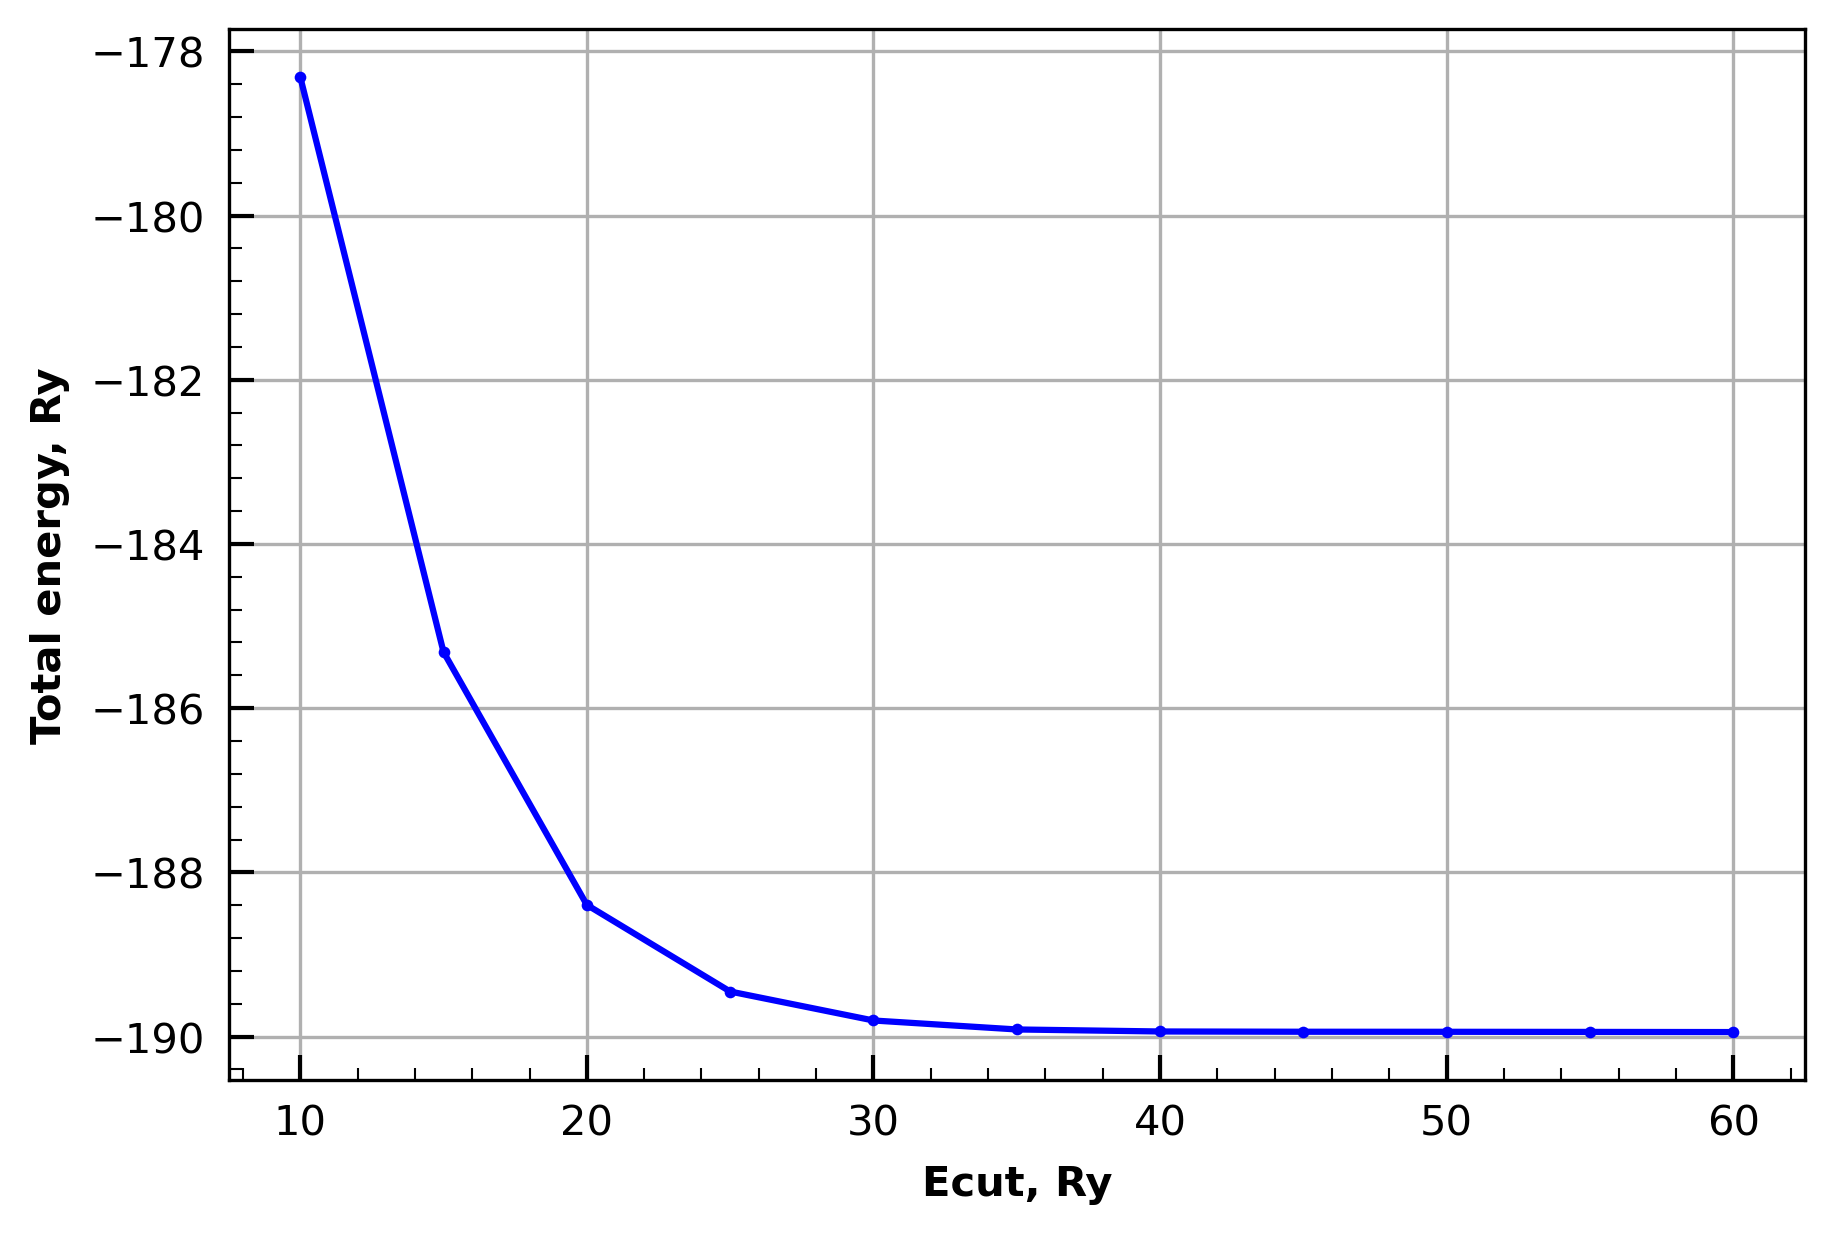

In [ ]:
# Find Total energies
total_energies = np.array([get_total_energy(outfile=general_paths[struc].qe_opt_params.cutoff_energy_opt.__val__ / str(i+1) / 'espresso.pwo', file_num=str(i+1)) for i in range(len(cutoff_energies))])

# Make Figure
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300, constrained_layout=True)

ax.plot(cutoff_energies, total_energies, label='', color='blue', marker='.', linewidth=1.5)
ax.set_xlabel('Ecut, Ry', fontsize=10, fontweight='bold', labelpad=5)
ax.set_ylabel('Total energy, Ry', fontsize=10, fontweight='bold', labelpad=5)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='both', which='major', direction='in',
               top=False, right=False, labelsize=10,
               length=6, width=1)

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(axis='both', which='minor', direction='in',
               top=False, right=False,
               length=3, width=0.5)
ax.grid(True)
fig.savefig(
    general_paths.figures / "ecut_energy_opt.pdf",
    dpi=600,
    transparent=True,
    bbox_inches='tight'
)

## PART 1.2 - K-points Grid Optimization

### **General Workflow**
✅4) **Implement SCF calculations for k-points grid optimization**
- Copy function **get_scf_params** from the previous step.

You can read **DOCUMENTATION for INPUT** files: <br>
https://www.quantum-espresso.org/documentation/input-data-description/

- In the next cell, **cutoff_energy** and **kpts_grid** must be wisely specified. **cutoff_energy** must be chosen from the previous step and will be fixed, while **kpts_grid** will be iteratively inserted into INPUT files and SCF will be implemented.

- After implementation above steps, please, go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/*struc*/1.Optimization/1.2.Kpoints_Optimization <br>

🌟Run calculations: **sbatch scf_script.sh** <br>
If calculations successfully finished, you will see note **JOB DONE** in the **espresso.pwo** files. If it is done, you can go to the next step.

- In the visualisation part, you need run cells and obtain the figure. This figure must be used in your **Lab Report**

### SCF Calculation

In [53]:
%%writefile {general_paths[struc].qe_opt_params.kpoints_opt.__val__  / 'QE_SCF_script.py'}

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import re
import ast
from ase.calculators.espresso import Espresso, EspressoProfile
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import argparse
import sys
from pathlib import Path, PurePath

parser = argparse.ArgumentParser(description='Process input data')
parser.add_argument('--main_dir', type=str, help='Enter path to the main directory')
parser.add_argument('--struc', type=str, help='Enter structure name: (e.g. Diamane)')
parser.add_argument('--cutoff_energy', type=int)
parser.add_argument('--kpts_grid', type=str)
args = parser.parse_args()

kpts_grid = ast.literal_eval(args.kpts_grid)
sys.path.append(args.main_dir + '/python_files')
from util_functions import *

general_paths_dir = Path(args.main_dir) / args.struc / 'utils' / 'general_paths.yaml'
if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

command = 'sh qe_run.sh'

def get_scf_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,

):
    scf_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                'restart_mode': 'from_scratch',
                'calculation': 'scf',
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high'
            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'ecutwfc': ecutwfc,
                'ecutrho': ecutwfc*8,     # ! 8*ecutwfc
                'nosym': True,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.05,
            },
            'electrons': {
                'conv_thr': 1.0e-8,
                'mixing_beta': 0.4,
                'diagonalization': 'cg'
            },
            'ions': {
                'ion_dynamics': 'bfgs'
            }
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return scf_params

if __name__ == '__main__':
    for i, kpts in enumerate(kpts_grid):
        # Create Folder
        folder_name = create_folder(main_dir=general_paths[args.struc].qe_opt_params.kpoints_opt.__val__, folder=str(i+1))
        structure = read(general_paths.utils / 'POSCAR')

        os.system(f'cp {general_paths[args.struc].qe_opt_params.__val__ / "qe_run.sh"} {folder_name}')
        os.chdir(folder_name)

        # SCF
        scf_params = get_scf_params(
            command=command,
            pseudo_dir=general_paths.utils,
            structure=structure,
            prefix=i+1,
            ecutwfc=args.cutoff_energy,
            kpts_grid=kpts,
        )
        calc = Espresso(**scf_params)
        structure.calc = calc
        structure.get_potential_energy()
        print(f'\nSCF {i+1} finished successfully\n')

Writing /home/heimao/Desktop/hasaki/Diamane/1.Optimization/1.2.Kpoints_Optimization/QE_SCF_script.py


In [54]:
# Choose optimal cut-off energy from previous step
cutoff_energy = 45 # CHANGE HERE
# Make kpoints grid
kpts_grid = [(i, i, 1) for i in range(6, 13, 1)] # CHANGE HERE

create_bash_script(
script_filename=general_paths[struc].qe_opt_params.kpoints_opt.__val__ / 'scf_script.sh',
job_name='qe-scf',
partition='cpu',
nodes=1,
memory='6G',
exclude='',
ntasks=4,
cpus_per_task=1,
gpus=0,
time=24,
command=f'python QE_SCF_script.py \
    --struc={struc} \
    --main_dir={os.getcwd()} \
    --cutoff_energy={cutoff_energy} \
    --kpts_grid="{str(kpts_grid)}"'
)

> **RUN CALCULATIONS** <br>

`sbatch scf_script.sh`

### Visualization

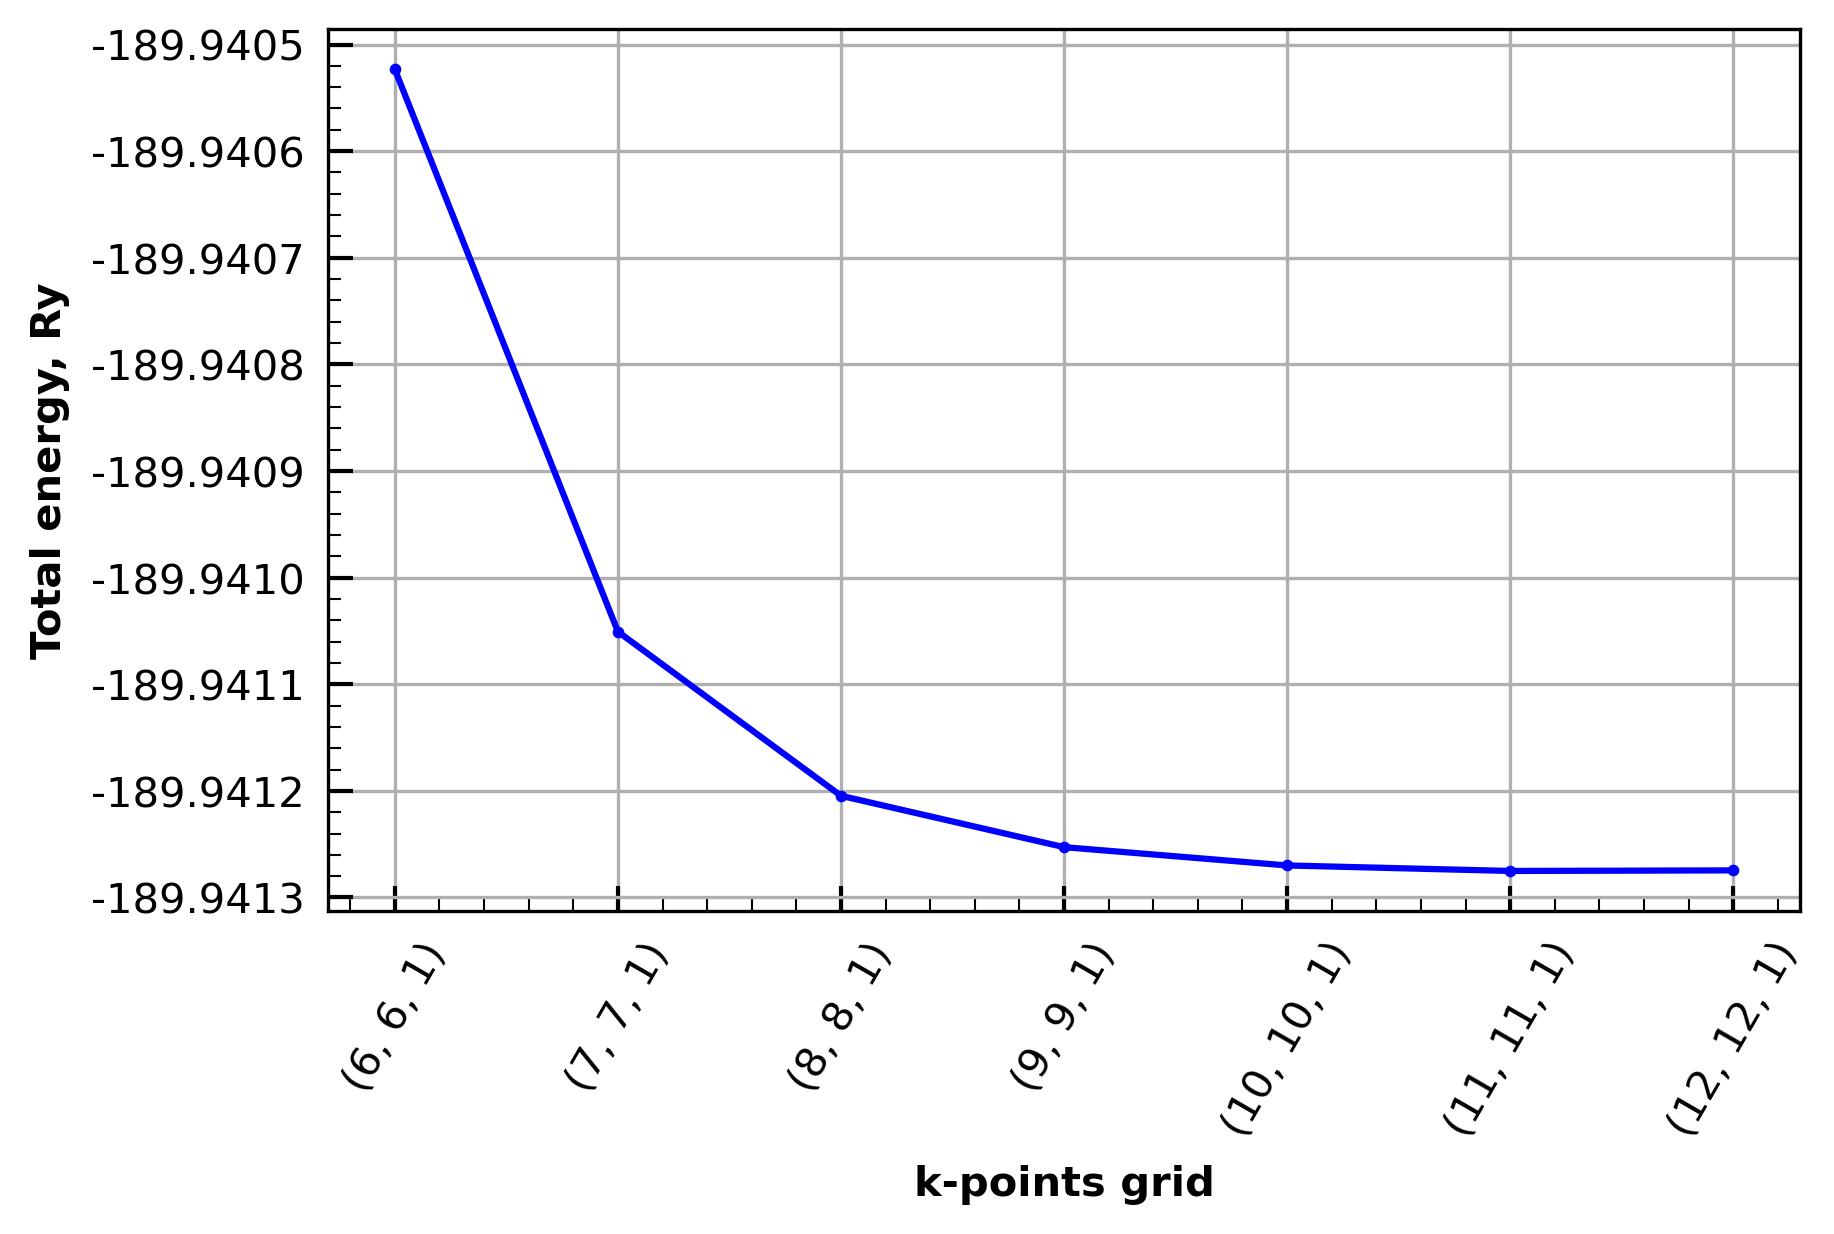

In [55]:
# Find Total energies
total_energies = np.array([get_total_energy(outfile=general_paths[struc].qe_opt_params.kpoints_opt.__val__ / str(i+1) / 'espresso.pwo', file_num=str(i+1)) for i in range(len(kpts_grid))])

# Make Figure
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300, constrained_layout=True)

ax.plot(np.arange(len(kpts_grid)), total_energies, label='', color='blue', marker='.', linewidth=1.5)
ax.set_xlabel('k-points grid', fontsize=10, fontweight='bold', labelpad=5)
ax.set_ylabel('Total energy, Ry', fontsize=10, fontweight='bold', labelpad=5)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

ax.set_xticks(np.arange(len(kpts_grid)))
ax.set_xticklabels(kpts_grid, rotation=60)
ax.tick_params(axis='both', which='major', direction='in',
               top=False, right=False, labelsize=10,
               length=6, width=1)

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(axis='both', which='minor', direction='in',
               top=False, right=False,
               length=3, width=0.5)
ax.grid(True)
fig.savefig(
    general_paths.figures / "kpoints_grid_opt.pdf",
    dpi=600,
    transparent=True,
    bbox_inches='tight'
)

## PART 1.3 - Relaxation with Optimized Parameters

### **General Workflow**
✅5) **Implement Structure Relaxation**
- Choose previously optimized **cutoff_energy** and **kpts** and insert them into the function **get_vcrelax_params** in the cell.

- After implementation above steps, please, go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/*struc*/1.Optimization/1.3.Relaxation <br>

🌟Run calculations: **sbatch relax_script.sh** <br>
If calculations successfully finished, you will see note **JOB DONE** in the **espresso.pwo** files. If it is done, you can go to the next step.

### Relaxation

In [58]:
%%writefile {general_paths[struc].qe_opt_params.relaxation.__val__  / 'QE_relax_script.py'}

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import re
import ast
from ase.calculators.espresso import Espresso, EspressoProfile
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import argparse
import sys
from pathlib import Path, PurePath

parser = argparse.ArgumentParser(description='Process input data')
parser.add_argument('--main_dir', type=str, help='Enter path to the main directory')
parser.add_argument('--struc', type=str, help='Enter structure name: (e.g. Diamane)')
parser.add_argument('--cutoff_energy', type=int)
parser.add_argument('--kpts', type=str)
args = parser.parse_args()

kpts = ast.literal_eval(args.kpts)
sys.path.append(args.main_dir + '/python_files')
from util_functions import *

general_paths_dir = Path(args.main_dir) / args.struc / 'utils' / 'general_paths.yaml'
if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

command = 'sh qe_run.sh'

def get_vcrelax_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,

):
    vcrelax_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                'calculation': 'vc-relax',
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high',
                'nstep': 1000,
                'etot_conv_thr': 1.0e-5,
                'forc_conv_thr': 1.0e-4,

            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'ecutwfc': ecutwfc,
                'nosym': True,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.05,
            },
            'electrons': {
                'conv_thr': 1.0e-8,
                'electron_maxstep': 100,
                'mixing_beta': 0.4,
                'diagonalization': 'cg',
            },
            'ions': {
                'ion_dynamics': 'bfgs',
                'pot_extrapolation': 'first_order',
            },
            'cell': {
                'cell_dynamics': 'bfgs',
                'cell_dofree': '2Dxy',
                'press': 0,
            }
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return vcrelax_params

if __name__ == '__main__':

    folder_name = general_paths[args.struc].qe_opt_params.relaxation.__val__
    structure = read(general_paths.utils / 'POSCAR')

    os.system(f'cp {general_paths[args.struc].qe_opt_params.__val__ / "qe_run.sh"} {folder_name}')
    os.chdir(folder_name)

    # Relaxation
    vcrelax_params = get_vcrelax_params(
        command=command,
        pseudo_dir=general_paths.utils,
        structure=structure,
        prefix=args.struc,
        ecutwfc=args.cutoff_energy,
        kpts_grid=kpts,
    )
    calc = Espresso(**vcrelax_params)
    structure.calc = calc
    structure.get_potential_energy()
    print(f'\nRelaxation finished successfully\n')

Overwriting /home/heimao/Desktop/hasaki/Diamane/1.Optimization/1.3.Relaxation/QE_relax_script.py


In [59]:
# Choose optimal cut-off energy from previous step
cutoff_energy = 45 # CHANGE HERE
# Choose optimal kpoints grid from previous step
kpts = [12, 12, 1] # CHANGE HERE

create_bash_script(
script_filename=general_paths[struc].qe_opt_params.relaxation.__val__ / 'relax_script.sh',
job_name='qe-relax',
partition='cpu',
nodes=1,
memory='6G',
exclude='',
ntasks=4,
cpus_per_task=1,
gpus=0,
time=24,
command=f'python QE_relax_script.py \
    --struc={struc} \
    --main_dir={os.getcwd()} \
    --cutoff_energy={cutoff_energy} \
    --kpts="{str(kpts)}"'
)

> **RUN CALCULATIONS** <br>

`sbatch relax_script.sh`